#### Code below is from given generate_lumpy_background.py file (just for visual reference)

import numpy as np

def generate_lumpy_background(dim=(64, 64), N_bar=15, a=1, w_b=3):
    """
    Generate a lumpy background based on a 2D Gaussian model

    Args:
    - dim (tuple): Dimensions of the background image
    - N_bar (int): Mean number of lumps (Poisson distribution parameter)
    - a (float): Lump amplitude
    - w_b (float): Lump width (standard deviation of Gaussian)

    Returns:
    - background (2D array): The generated lumpy background
    """
    N_b = np.random.poisson(N_bar)  # Number of lumps sampled from Poisson distribution
    background = np.zeros(dim)

    # Create lumps at random positions
    for _ in range(N_b):
        # Sample random position for the lump center
        r_n = np.random.randint(0, dim[0]), np.random.randint(0, dim[1])

        # Generate a Gaussian lump
        X, Y = np.meshgrid(np.arange(dim[0]), np.arange(dim[1]))
        r = np.stack([X, Y], axis=-1)
        dist = np.sum((r - r_n) ** 2, axis=-1)
        lump = a * np.exp(-dist / (2 * w_b ** 2))

        # Add lump to the background
        background += lump

    return background

In [211]:
import numpy as np, numpy.linalg as la
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import seaborn as sns
import os, cv2
from joblib import Parallel, delayed

In [2]:
from generate_lumpy_background import generate_lumpy_background

### Noise generation helper functions

In [112]:
def add_gaussian_blob(img, size=3,ampl=2):
    h, w = img.shape
    x_cent = h // 2
    y_cent = w // 2

    y_coords,x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')

    dist_sq = (x_coords - x_cent)**2 + (y_coords - y_cent)**2
    blob = ampl * np.exp(-dist_sq / (2 * size**2))

    return img + blob

In [113]:
def add_noise(img, noise_stdev):
    noise = np.random.normal(0, noise_stdev, img.shape)
    return img + noise

## Main dataset generation

In [180]:
def gen_imgs(N_samples, N_bar=15,a=1,w_b=3, signal_present=True,noise_stdev=1):
    data = []
    labels = []

    for i in range(N_samples):
        bg = generate_lumpy_background(N_bar=N_bar,a=a,w_b=w_b)
        
        if signal_present:
            bg = add_gaussian_blob(bg)
            labels.append(1)
        else:
            labels.append(0)
            
        noisy_img = add_noise(bg, noise_stdev)
        data.append(noisy_img.flatten())

    return np.array(data), np.array(labels)

In [181]:
# generates test and train data,
#     params:
#        N_train: # imgs in train set
#        N_test:  # imgs in test set

def generate_dataset(N_train, N_test, N_bar=15, a=1, w_b=3, noise_stdev=1):
    
    # generating train data
    X_train_none, y_train_none = gen_imgs(N_train,N_bar=N_bar,a=a,w_b=w_b,signal_present=False,noise_stdev=noise_stdev)
    X_train_signal, y_train_signal = gen_imgs(N_train,N_bar=N_bar,a=a,w_b=w_b,signal_present=True,noise_stdev=noise_stdev)
    
    X_train = np.vstack([X_train_none, X_train_signal])
    y_train = np.concatenate([y_train_none, y_train_signal])
    X_train, y_train = shuffle(X_train, y_train, random_state=11)

    # generating test data
    X_test_none, y_test_none = gen_imgs(N_test,N_bar=N_bar,a=a,w_b=w_b,signal_present=False,noise_stdev=noise_stdev)
    X_test_signal, y_test_signal = gen_imgs(N_test,N_bar=N_bar,a=a,w_b=w_b,signal_present=True,noise_stdev=noise_stdev)
    
    X_test = np.vstack([X_test_none, X_test_signal])
    y_test = np.concatenate([y_test_none, y_test_signal])
    X_test, y_test = shuffle(X_test, y_test, random_state=11)
    
    return X_train, y_train, X_test, y_test

### Hotelling Observer

In [182]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [183]:
def hotelling_observer(X_train, y_train, X_test):
    # X_0 = X_train[y_train == 0]
    # X_1 = X_train[y_train == 1]

    # mean_0 = np.mean(X_0, axis=0)
    # mean_1 = np.mean(X_1, axis=0)

    # cov = np.cov(X_train.T)
    # cov_inv = np.linalg.pinv(cov)
    
    # w = cov_inv @ (mean_1 - mean_0)

    # scores = X_test @ w
    lda = LinearDiscriminantAnalysis(solver='svd')
    lda.fit(X_train, y_train)
    scores = lda.decision_function(X_test)
    return scores

### Channelized Hotelling Observer

In [184]:
def create_laguerre_gauss_channels(dim=(64,64), sigmas=[3, 6, 9]):
    X, Y = np.meshgrid(np.arange(dim[1]), np.arange(dim[0]))
    x0, y0 = dim[1]//2, dim[0]//2
    r2 = (X - x0)**2 + (Y - y0)**2
    channels = []
    for s in sigmas:
        ch = np.exp(-r2 / (2 * s**2))
        ch /= np.linalg.norm(ch)  # normalize
        channels.append(ch)
    return np.array(channels)

def apply_channels(flat_images, channels, image_shape=(64, 64)):
    # C, H, W = channels.shape
    # N = flat_images.shape[0]
    # output = np.zeros((N, C))
    
    # for i in range(N):
    #     img = flat_images[i].reshape(image_shape)
    #     for c in range(C):
    #         output[i, c] = np.sum(img * channels[c])
    C, H, W = channels.shape
    N = flat_images.shape[0]
    imgs = flat_images.reshape(N, H, W)
    output = np.einsum('nxy,cxy->nc', imgs, channels)
        
    return output

In [185]:
def create_gabor_channels(dim=(64,64)):#, freqs=[0.1, 0.2], thetas=[0, np.pi/4, np.pi/2]):
    # X, Y = np.meshgrid(np.linspace(-1, 1, dim[1]), np.linspace(-1, 1, dim[0]))
    # channels = []
    # for f in freqs:
    #     for theta in thetas:
    #         X_theta = X * np.cos(theta) + Y * np.sin(theta)
    #         gb = np.exp(-0.5 * X_theta**2) * np.cos(2 * np.pi * f * X_theta)
    #         gb /= np.linalg.norm(gb)  # normalize
    #         channels.append(gb)
    # return np.array(channels)
    freqs = [3/256, 3/128, 3/64, 3/32, 3/16, 3/8]
    thetas = [0, 2*np.pi/5, 4*np.pi/5, 6*np.pi/5, 8*np.pi/5]
    phases = [0, np.pi/2]
    
    X, Y = np.meshgrid(np.linspace(-1, 1, dim[1]), np.linspace(-1, 1, dim[0]))
    channels = []

    for f in freqs:
        w_i = 1 / f  # approximate width; can tune this
        for theta in thetas:
            X_theta = X * np.cos(theta) + Y * np.sin(theta)
            for phi in phases:
                envelope = np.exp(-(4 * np.log(2)) * (X**2 + Y**2) / (w_i ** 2))
                gabor = envelope * np.cos(2 * np.pi * f * X_theta + phi)
                gabor /= np.linalg.norm(gabor)
                channels.append(gabor)
    
    return np.array(channels)

In [186]:
def cho_observer(X_train, y_train, X_test, channels, image_shape=(64,64)):
    X_train_chan = apply_channels(X_train, channels, image_shape)
    X_test_chan = apply_channels(X_test, channels, image_shape)

    X0 = X_train_chan[y_train == 0]
    X1 = X_train_chan[y_train == 1]

    mean0 = np.mean(X0, axis=0)
    mean1 = np.mean(X1, axis=0)

    # cov = np.cov(X_train_chan.T)
    # w = np.linalg.inv(cov + 1e-3 * np.eye(cov.shape[0])) @ (mean1 - mean0)
    cov = 0.5 * (np.cov(X0, rowvar=False) + np.cov(X1, rowvar=False))
    cov += 1e-3 * np.eye(cov.shape[0])
    w = np.linalg.solve(cov, mean1 - mean0)

    return X_test_chan @ w 

## Main loop

In [234]:
lump_counts = [15,100]    # N_bar
lump_sizes = [3,10]    # w_b
lump_amplitudes = [3,10]    # a

noise_levels = [1, 2, 3] # gaussian stdevs

In [241]:
results = []
trial_idx = 0
N_train, N_test = 10000,1000

for N_bar in lump_counts:
    for w_b in lump_sizes:
        for a in lump_amplitudes:
            for noise_stdev in noise_levels:
                trial_idx += 1
                print(f"Trial {trial_idx}: (N_bar={N_bar}, w_b={w_b}, a={a}, noise={noise_stdev})")

                start = time.time()
                X_train, y_train, X_test, y_test = generate_dataset(N_train, N_test, N_bar, a, w_b, noise_stdev)

                scores_ho = hotelling_observer(X_train, y_train, X_test)
                auc_ho = roc_auc_score(y_test, scores_ho)

                lg_channels = create_laguerre_gauss_channels()
                scores_cho_lg = cho_observer(X_train, y_train, X_test, lg_channels)
                auc_lg = roc_auc_score(y_test, scores_cho_lg)

                gabor_channels = create_gabor_channels()
                scores_cho_gabor = cho_observer(X_train, y_train, X_test, gabor_channels)
                auc_gabor = roc_auc_score(y_test, scores_cho_gabor)
                end = time.time()
                
                print(f"    HO: {auc_ho:.3f}    CHO-LG: {auc_lg:.3f}    CHO-Gabor: {auc_gabor:.3f}")
                print(f"    Time taken: {end-start} seconds")
                results.append({
                    'trial': trial_idx,
                    'N_bar': N_bar,
                    'w_b': w_b,
                    'a': a,
                    'noise_stdev': noise_stdev,
                    'auc_ho': auc_ho,
                    'auc_lg': auc_lg,
                    'auc_gabor': auc_gabor,
                    'time_taken': end-start
                })

Trial 1: (N_bar=15, w_b=3, a=3, noise=1)
    HO: 0.909    CHO-LG: 0.910    CHO-Gabor: 0.662
    Time taken: 105.28546166419983 seconds
Trial 2: (N_bar=15, w_b=3, a=3, noise=2)
    HO: 0.872    CHO-LG: 0.908    CHO-Gabor: 0.642
    Time taken: 109.8712067604065 seconds
Trial 3: (N_bar=15, w_b=3, a=3, noise=3)
    HO: 0.829    CHO-LG: 0.886    CHO-Gabor: 0.660
    Time taken: 103.51904845237732 seconds
Trial 4: (N_bar=15, w_b=3, a=10, noise=1)
    HO: 0.644    CHO-LG: 0.703    CHO-Gabor: 0.537
    Time taken: 107.97554326057434 seconds
Trial 5: (N_bar=15, w_b=3, a=10, noise=2)
    HO: 0.614    CHO-LG: 0.720    CHO-Gabor: 0.560
    Time taken: 106.60510993003845 seconds
Trial 6: (N_bar=15, w_b=3, a=10, noise=3)
    HO: 0.605    CHO-LG: 0.686    CHO-Gabor: 0.549
    Time taken: 107.54730129241943 seconds
Trial 7: (N_bar=15, w_b=10, a=3, noise=1)
    HO: 1.000    CHO-LG: 0.999    CHO-Gabor: 0.565
    Time taken: 110.92563939094543 seconds
Trial 8: (N_bar=15, w_b=10, a=3, noise=2)
    HO: 0.

In [243]:
df = pd.DataFrame(results)
df.to_csv("results.csv",index=False)

## Plots

#### AUC vs Lump count

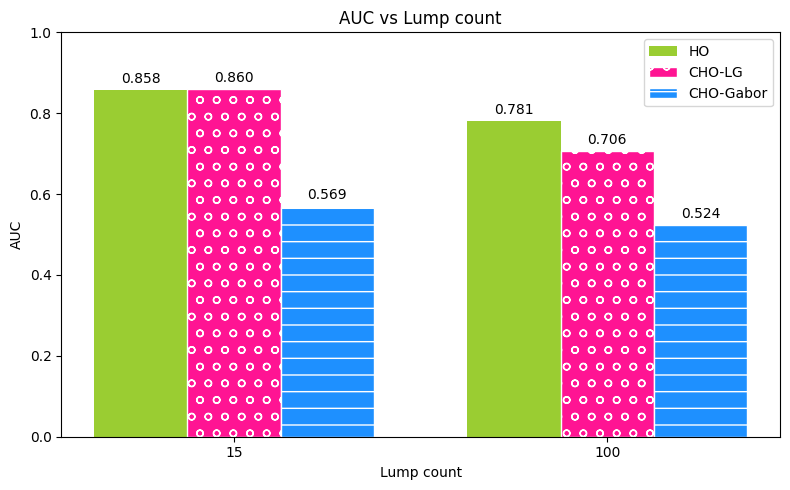

In [244]:
grouped = df.groupby('N_bar').mean(numeric_only=True)

x = np.arange(len(grouped.index))
width = 0.25  # bar width

fig, ax = plt.subplots(figsize=(8, 5))
bars_ho=ax.bar(x - width, grouped['auc_ho'], width, label='HO',color="yellowgreen")
bars_lg=ax.bar(x, grouped['auc_lg'], width, label='CHO-LG',color="deeppink",hatch='o',edgecolor='white')
bars_gabor=ax.bar(x + width, grouped['auc_gabor'], width, label='CHO-Gabor',color="dodgerblue",hatch='-',edgecolor='white')


ax.bar_label(bars_ho, fmt='%.3f', padding=3)
ax.bar_label(bars_lg, fmt='%.3f', padding=3)
ax.bar_label(bars_gabor, fmt='%.3f', padding=3)


ax.set_xlabel('Lump count')
ax.set_ylabel('AUC')

ax.set_xticks(x)
ax.set_xticklabels(grouped.index)

ax.set_title('AUC vs Lump count')
ax.legend()
plt.ylim(0, 1)
# ax.grid(True)
plt.tight_layout()
plt.show()

#### AUC vs Lump size

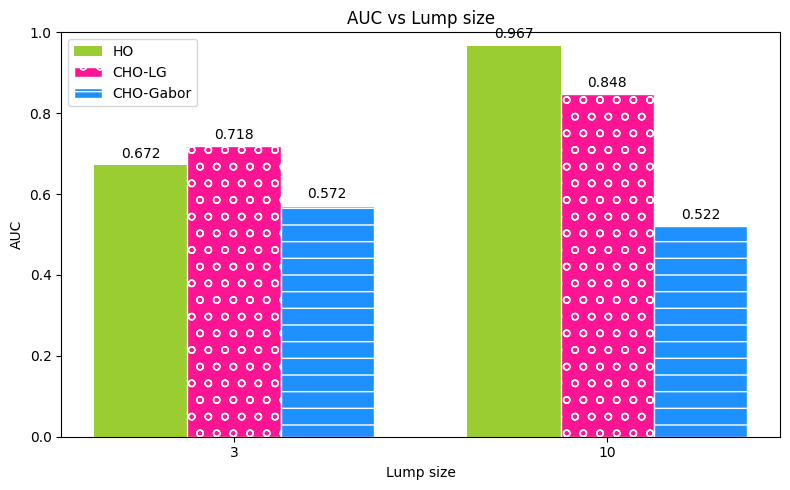

In [245]:
grouped = df.groupby('w_b').mean(numeric_only=True)

x = np.arange(len(grouped.index))
width = 0.25  # bar width

fig, ax = plt.subplots(figsize=(8, 5))
bars_ho=ax.bar(x - width, grouped['auc_ho'], width, label='HO',color="yellowgreen")
bars_lg=ax.bar(x, grouped['auc_lg'], width, label='CHO-LG',color="deeppink",hatch='o',edgecolor='white')
bars_gabor=ax.bar(x + width, grouped['auc_gabor'], width, label='CHO-Gabor',color="dodgerblue",hatch='-',edgecolor='white')


ax.bar_label(bars_ho, fmt='%.3f', padding=3)
ax.bar_label(bars_lg, fmt='%.3f', padding=3)
ax.bar_label(bars_gabor, fmt='%.3f', padding=3)


ax.set_xlabel('Lump size')
ax.set_ylabel('AUC')

ax.set_xticks(x)
ax.set_xticklabels(grouped.index)

ax.set_title('AUC vs Lump size')
ax.legend()
plt.ylim(0, 1)
# ax.grid(True)
plt.tight_layout()
plt.show()

#### AUC vs Amplitude

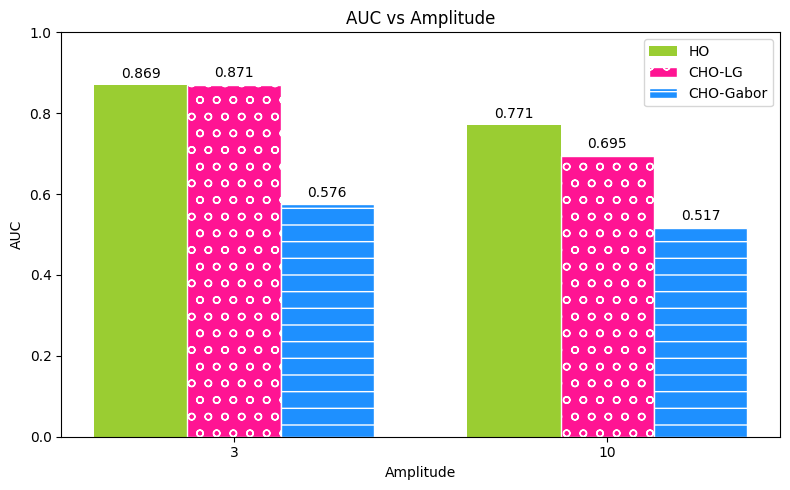

In [246]:
grouped = df.groupby('a').mean(numeric_only=True)

x = np.arange(len(grouped.index))
width = 0.25  # bar width

fig, ax = plt.subplots(figsize=(8, 5))
bars_ho=ax.bar(x - width, grouped['auc_ho'], width, label='HO',color="yellowgreen")
bars_lg=ax.bar(x, grouped['auc_lg'], width, label='CHO-LG',color="deeppink",hatch='o',edgecolor='white')
bars_gabor=ax.bar(x + width, grouped['auc_gabor'], width, label='CHO-Gabor',color="dodgerblue",hatch='-',edgecolor='white')


ax.bar_label(bars_ho, fmt='%.3f', padding=3)
ax.bar_label(bars_lg, fmt='%.3f', padding=3)
ax.bar_label(bars_gabor, fmt='%.3f', padding=3)


ax.set_xlabel('Amplitude')
ax.set_ylabel('AUC')

ax.set_xticks(x)
ax.set_xticklabels(grouped.index)

ax.set_title('AUC vs Amplitude')
ax.legend()
plt.ylim(0, 1)
# ax.grid(True)
plt.tight_layout()
plt.show()

#### AUC vs Noise level

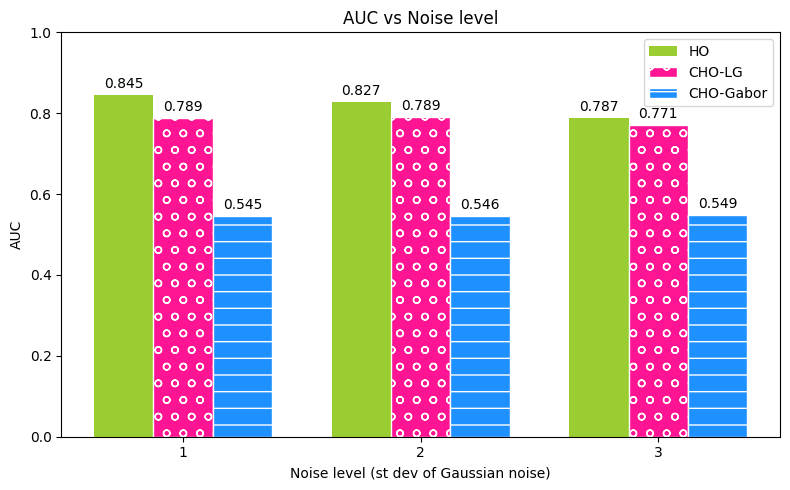

In [247]:
grouped = df.groupby('noise_stdev').mean(numeric_only=True)

x = np.arange(len(grouped.index))
width = 0.25  # bar width

fig, ax = plt.subplots(figsize=(8, 5))
bars_ho=ax.bar(x - width, grouped['auc_ho'], width, label='HO',color="yellowgreen")
bars_lg=ax.bar(x, grouped['auc_lg'], width, label='CHO-LG',color="deeppink",hatch='o',edgecolor='white')
bars_gabor=ax.bar(x + width, grouped['auc_gabor'], width, label='CHO-Gabor',color="dodgerblue",hatch='-',edgecolor='white')


ax.bar_label(bars_ho, fmt='%.3f', padding=3)
ax.bar_label(bars_lg, fmt='%.3f', padding=3)
ax.bar_label(bars_gabor, fmt='%.3f', padding=3)


ax.set_xlabel('Noise level (st dev of Gaussian noise)')
ax.set_ylabel('AUC')

ax.set_xticks(x)
ax.set_xticklabels(grouped.index)

ax.set_title('AUC vs Noise level')
ax.legend()
plt.ylim(0, 1)
# ax.grid(True)
plt.tight_layout()
plt.show()